In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [2]:
def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

In [3]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    
    # ROC curve
    plt.subplot(1, 2, 2)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Call the function with your model and test generator


In [4]:
train_dir = r"/kaggle/input/leaf-dataset/augmented/train"
test_dir = r"/kaggle/input/leaf-dataset/augmented/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)
# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

Found 5000 images belonging to 30 classes.
Found 2500 images belonging to 30 classes.
{0: 1.2820512820512822, 1: 0.4975124378109453, 2: 1.0101010101010102, 3: 1.016260162601626, 4: 0.5827505827505828, 5: 1.8726591760299625, 6: 0.778816199376947, 7: 1.2345679012345678, 8: 1.1111111111111112, 9: 0.9057971014492754, 10: 1.3440860215053763, 11: 0.8680555555555556, 12: 0.9009009009009009, 13: 0.6587615283267457, 14: 0.778816199376947, 15: 1.3123359580052494, 16: 0.9416195856873822, 17: 1.02880658436214, 18: 1.4880952380952381, 19: 1.1037527593818985, 20: 1.4492753623188406, 21: 1.3888888888888888, 22: 1.0040160642570282, 23: 1.0964912280701755, 24: 0.8169934640522876, 25: 0.8960573476702509, 26: 1.529051987767584, 27: 1.0964912280701755, 28: 1.1574074074074074, 29: 1.6181229773462784}


In [5]:
!pip install keras_cv_attention_models 

  Obtaining dependency information for keras_cv_attention_models from https://files.pythonhosted.org/packages/f0/02/d10f684e57fc993cc90c9c7610df4e77239f8d1c395f67c3e687109eae6b/keras_cv_attention_models-1.3.23-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/31/b1/a59de0ad3aabb17523a39804f4c6df3ae87ead053a4e25362ae03d73d03a/wcwidth-0.2.12-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.9/786.9 kB 9.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstallin

In [6]:
from keras_cv_attention_models import wave_mlp

In [11]:
pip install keras-self-attention


Note: you may need to restart the kernel to use updated packages.


In [7]:
def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")

    # Add your custom head
    head_output = custom_head(mm_headless.output, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    # Fine-tune the last few layers of the base model
    for layer in mm_headless.layers[:-15]:
        layer.trainable = True

    # Compile the model with a custom learning rate and metrics
    custom_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()

69906376/69906376 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/wavemlp_t_imagenet.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 stem_pad (ZeroPadding2D)    (None, 116, 116, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 28, 28, 64)           9472      ['stem_pad[0][0]']            
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 28, 28, 64)           2

In [8]:
input_shape = (112, 112, 3)
num_classes = 30

# Assign the result of modify_wave_mlp to a variable
custom_model = modify_wave_mlp(input_shape, num_classes)

# Now you can use custom_model outside of the function
mm_last_layer = custom_model.get_layer('avg_pool').output
mm_custom = Model(custom_model.input, mm_last_layer)


>>>> Load pretrained from: /root/.keras/models/wavemlp_t_imagenet.h5


In [ ]:
custom_model.summary()

In [9]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 512)               16704736  
                                                                 
 average (Average)           (None, 512)               0         
                                                                 
Total params: 16704736 (63.72 MB)
Trainable params: 16680160 (63.63 MB)
Non-trainable params: 24576 (96.00 KB)
_________________________________________________________________


In [10]:
num_classes = 30
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 512)               16704736  
                                                                 
 average (Average)           (None, 512)               0         
                                                                 
 output_1 (Dense)            (None, 30)                15390     
                                                                 
Total params: 16720126 (63.78 MB)
Trainable params: 16695550 (63.69 MB)
Non-trainable params: 24576 (96.00 KB)
_________________________________________________________________


In [11]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath='Best_DenseNet201_v23.h5', save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [14]:
epochs = 10

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

/tmp/ipykernel_43/3461117181.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(generator=generator_train,


Epoch 1/10
313/312 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7976 - categorical_accuracy: 0.7976 - auc: 0.9850 - precision: 0.8489 - recall: 0.7428 - true_positives: 3714.0000 - true_negatives: 144339.0000 - false_positives: 661.0000 - false_negatives: 1286.0000 - cohen_kappa: 0.7901 - f1_score: 0.7937
Epoch 1: val_accuracy improved from -inf to 0.84440, saving model to Best_DenseNet201_v23.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


312/312 [==============================] - 108s 345ms/step - loss: 0.6703 - accuracy: 0.7976 - categorical_accuracy: 0.7976 - auc: 0.9850 - precision: 0.8489 - recall: 0.7428 - true_positives: 3714.0000 - true_negatives: 144339.0000 - false_positives: 661.0000 - false_negatives: 1286.0000 - cohen_kappa: 0.7901 - f1_score: 0.7937 - val_loss: 0.5294 - val_accuracy: 0.8444 - val_categorical_accuracy: 0.8444 - val_auc: 0.9878 - val_precision: 0.8779 - val_recall: 0.8200 - val_true_positives: 2050.0000 - val_true_negatives: 72215.0000 - val_false_positives: 285.0000 - val_false_negatives: 450.0000 - val_cohen_kappa: 0.8388 - val_f1_score: 0.8398 - lr: 0.0010
Epoch 2/10
313/312 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.8402 - categorical_accuracy: 0.8402 - auc: 0.9916 - precision: 0.8786 - recall: 0.8016 - true_positives: 4008.0000 - true_negatives: 144446.0000 - false_positives: 554.0000 - false_negatives: 992.0000 - cohen_kappa: 0.8342 - f1_score: 0.8355
Epoch

157/157 [==============================] - 23s 136ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        56
           1       0.99      0.88      0.93       153
           2       0.99      0.94      0.96        84
           3       0.97      0.90      0.94        72
           4       1.00      0.48      0.64       124
           5       0.87      1.00      0.93        47
           6       0.99      1.00      0.99        99
           7       0.74      0.96      0.84        84
           8       0.79      0.62      0.69        66
           9       1.00      1.00      1.00        84
          10       0.93      0.96      0.94        78
          11       0.58      1.00      0.74        75
          12       0.96      1.00      0.98        85
          13       0.86      0.99      0.92       126
          14       1.00      0.97      0.98        92
          15       1.00      0.88      0.93        89
          16       0.81

/tmp/ipykernel_43/2485669865.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


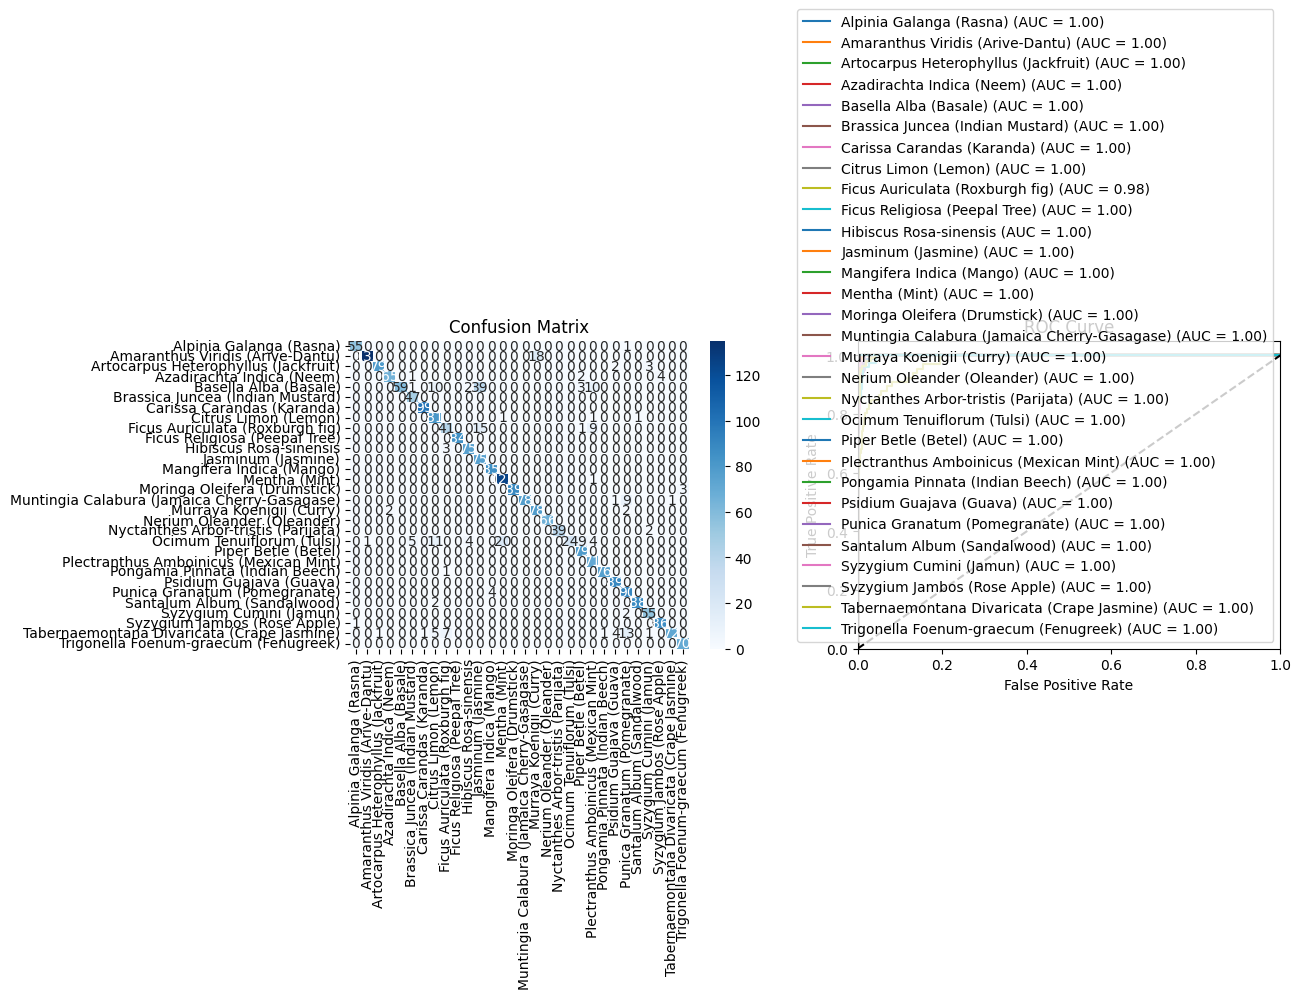

In [15]:
evaluate_(final_model, generator_test)

In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the custom image
custom_image_path = '/kaggle/input/leaf-dataset/augmented/val/Amaranthus Viridis (Arive-Dantu)/Amaranthus Viridis (Arive-Dantu)_original_AV-S-015.jpg_0a5141b7-7575-47a0-96ad-83d97d425ef6.jpg'
img = image.load_img(custom_image_path, target_size=(your_target_size))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image data if necessary

# Make predictions using the trained model
predictions = final_model.predict(img_array)

# Print or use the predictions as needed
print(predictions)


NameError: name 'your_target_size' is not defined

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the custom image
custom_image_path = '/kaggle/input/leaf-dataset/augmented/val/Amaranthus Viridis (Arive-Dantu)/Amaranthus Viridis (Arive-Dantu)_original_AV-S-015.jpg_0a5141b7-7575-47a0-96ad-83d97d425ef6.jpg'
target_size = (112, 112)  # Update with the expected input size of your model
img = image.load_img(custom_image_path, target_size=target_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image data if necessary

# Make predictions using the trained model
predictions = final_model.predict(img_array)

# Print or use the predictions as needed
print(predictions)


1/1 [==============================] - 4s 4s/step
[[4.8483074e-08 9.9908626e-01 2.0018048e-04 3.7226123e-08 2.2257804e-07
  5.6860749e-06 1.2829351e-04 2.3259395e-06 4.3110390e-08 6.0718770e-07
  6.3388843e-06 3.9781736e-07 1.1804353e-08 7.0301724e-07 2.6238713e-05
  2.1986035e-07 1.0729409e-04 3.6752166e-08 5.6689674e-07 2.4875683e-06
  3.6395943e-06 3.9570002e-04 1.0694956e-05 4.8435844e-08 3.1708101e-08
  1.4655192e-05 4.5318516e-06 2.8722695e-08 2.7526128e-06 6.5454863e-08]]


1/1 [==============================] - 0s 34ms/step


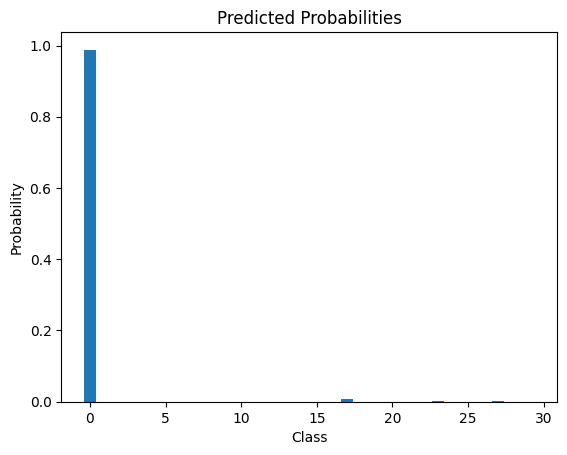

The model predicts the image belongs to class 0 with probability 0.99


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your custom image
custom_image_path = '/kaggle/input/leaf-dataset/augmented/test/Alpinia Galanga (Rasna)/Alpinia Galanga (Rasna)_original_AG-S-024.jpg_030eabde-80a5-4a6c-8c05-6fc5fc198028.jpg'
custom_image = cv2.imread(custom_image_path)
custom_image = cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB)  # If your image is in BGR format

# Preprocess the image based on how you preprocessed your training data
# Example: resize the image to match the input size of your model
input_size = (224, 224)  # Change this to your model's input size
custom_image = cv2.resize(custom_image, input_size)
custom_image = custom_image / 255.0  # Normalize the pixel values

# Expand dimensions to match the input shape expected by the model
custom_image = np.expand_dims(custom_image, axis=0)

# Make predictions using the trained model
predictions = final_model.predict(custom_image)

# Assuming binary classification, adjust accordingly for multi-class
predicted_class = np.argmax(predictions)

# Plot the predicted probabilities
plt.bar(range(predictions.shape[1]), predictions.ravel())
plt.title('Predicted Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.show()

print(f"The model predicts the image belongs to class {predicted_class} with probability {predictions[0][predicted_class]:.2f}")


1/1 [==============================] - 0s 33ms/step


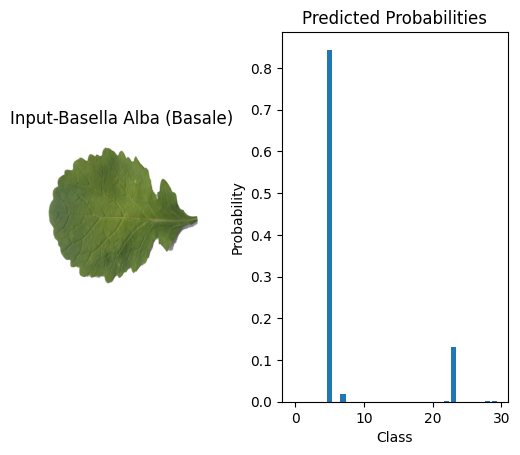

The model predicts the image belongs to class 5 with probability 0.84


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your custom image
custom_image_path = '/kaggle/input/leaf-dataset/augmented/val/Brassica Juncea (Indian Mustard)/Brassica Juncea (Indian Mustard)_original_BJ-S-012.jpg_12af27ec-2fe2-403f-bdd4-cd4fcee2c078.jpg'
custom_image = cv2.imread(custom_image_path)
custom_image = cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB)  # If your image is in BGR format

# Display the input image
plt.subplot(1, 2, 1)
plt.imshow(custom_image)
plt.title('Input-Basella Alba (Basale) ')
plt.axis('off')

# Preprocess the image based on how you preprocessed your training data
# Example: resize the image to match the input size of your model
input_size = (224, 224)  # Change this to your model's input size
custom_image = cv2.resize(custom_image, input_size)
custom_image = custom_image / 255.0  # Normalize the pixel values

# Expand dimensions to match the input shape expected by the model
custom_image = np.expand_dims(custom_image, axis=0)

# Make predictions using the trained model
predictions = final_model.predict(custom_image)

# Assuming binary classification, adjust accordingly for multi-class
predicted_class = np.argmax(predictions)

# Plot the predicted probabilities
plt.subplot(1, 2, 2)
plt.bar(range(predictions.shape[1]), predictions.ravel())
plt.title('Predicted Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')

plt.show()

print(f"The model predicts the image belongs to class {predicted_class} with probability {predictions[0][predicted_class]:.2f}")


1/1 [==============================] - 0s 35ms/step


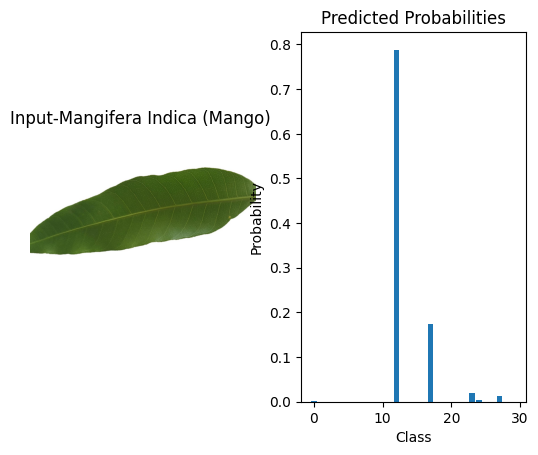

The model predicts the image belongs to class 12 with probability 0.79


In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your custom image
custom_image_path = '/kaggle/input/leaf-dataset/augmented/val/Mangifera Indica (Mango)/Mangifera Indica (Mango)_original_MI-S-011.jpg_43984077-7222-46b9-bffb-bf87e449b2fa.jpg'
custom_image = cv2.imread(custom_image_path)
custom_image = cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB)  # If your image is in BGR format

# Display the input image
plt.subplot(1, 2, 1)
plt.imshow(custom_image)
plt.title('Input-Mangifera Indica (Mango) ')
plt.axis('off')

# Preprocess the image based on how you preprocessed your training data
# Example: resize the image to match the input size of your model
input_size = (224, 224)  # Change this to your model's input size
custom_image = cv2.resize(custom_image, input_size)
custom_image = custom_image / 255.0  # Normalize the pixel values

# Expand dimensions to match the input shape expected by the model
custom_image = np.expand_dims(custom_image, axis=0)

# Make predictions using the trained model
predictions = final_model.predict(custom_image)

# Assuming binary classification, adjust accordingly for multi-class
predicted_class = np.argmax(predictions)

# Plot the predicted probabilities
plt.subplot(1, 2, 2)
plt.bar(range(predictions.shape[1]), predictions.ravel())
plt.title('Predicted Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')

plt.show()

print(f"The model predicts the image belongs to class {predicted_class} with probability {predictions[0][predicted_class]:.2f}")


1/1 [==============================] - 0s 33ms/step


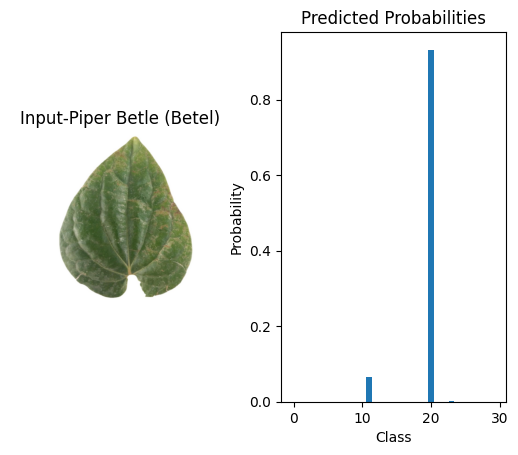

The model predicts the image belongs to class 20 with probability 0.93


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your custom image
custom_image_path = '/kaggle/input/leaf-dataset/augmented/val/Piper Betle (Betel)/Piper Betle (Betel)_original_PB-S-011.jpg_3a5687d9-3b70-4f78-93de-e168ebfdc2b1.jpg'
custom_image = cv2.imread(custom_image_path)
custom_image = cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB)  # If your image is in BGR format

# Display the input image
plt.subplot(1, 2, 1)
plt.imshow(custom_image)
plt.title('Input-Piper Betle (Betel) ')
plt.axis('off')

# Preprocess the image based on how you preprocessed your training data
# Example: resize the image to match the input size of your model
input_size = (224, 224)  # Change this to your model's input size
custom_image = cv2.resize(custom_image, input_size)
custom_image = custom_image / 255.0  # Normalize the pixel values

# Expand dimensions to match the input shape expected by the model
custom_image = np.expand_dims(custom_image, axis=0)

# Make predictions using the trained model
predictions = final_model.predict(custom_image)

# Assuming binary classification, adjust accordingly for multi-class
predicted_class = np.argmax(predictions)

# Plot the predicted probabilities
plt.subplot(1, 2, 2)
plt.bar(range(predictions.shape[1]), predictions.ravel())
plt.title('Predicted Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')

plt.show()

print(f"The model predicts the image belongs to class {predicted_class} with probability {predictions[0][predicted_class]:.2f}")


In [ ]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_img.jpg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
import time
import numpy as np
from PIL import Image  # Add this import statement

# Load a JPEG image
image_path = '/kaggle/input/leaf-dataset/augmented/val/Amaranthus Viridis (Arive-Dantu)/Amaranthus Viridis (Arive-Dantu)_original_AV-S-015.jpg_12e7805c-4aff-4f26-9f50-c89504450078.jpg'
test_image = Image.open(image_path)

# Depending on your model's input requirements, you might need to preprocess the image
# For example, if your model expects a specific input size:
target_size = (112, 112)  # Adjust this based on your model's input size
test_image = test_image.resize(target_size)
test_image_array = np.array(test_image)  # Convert to NumPy array if needed

# Repeat inference for a certain number of iterations to get an average time
num_iterations = 100
total_time = 0

for _ in range(num_iterations):
    start_time = time.time()
    predictions = final_model.predict(np.expand_dims(test_image_array, axis=0))
    end_time = time.time()
    inference_time = end_time - start_time
    total_time += inference_time

# Calculate average inference time
average_inference_time = total_time / num_iterations

# Calculate inference speed (predictions per second)
inference_speed = 1 / average_inference_time

print(f"Average Inference Time: {average_inference_time:.5f} seconds")
print(f"Inference Speed: {inference_speed:.2f} predictions per second")
